In [ ]:
! pip install pyautogui pillow matplotlib easyocr

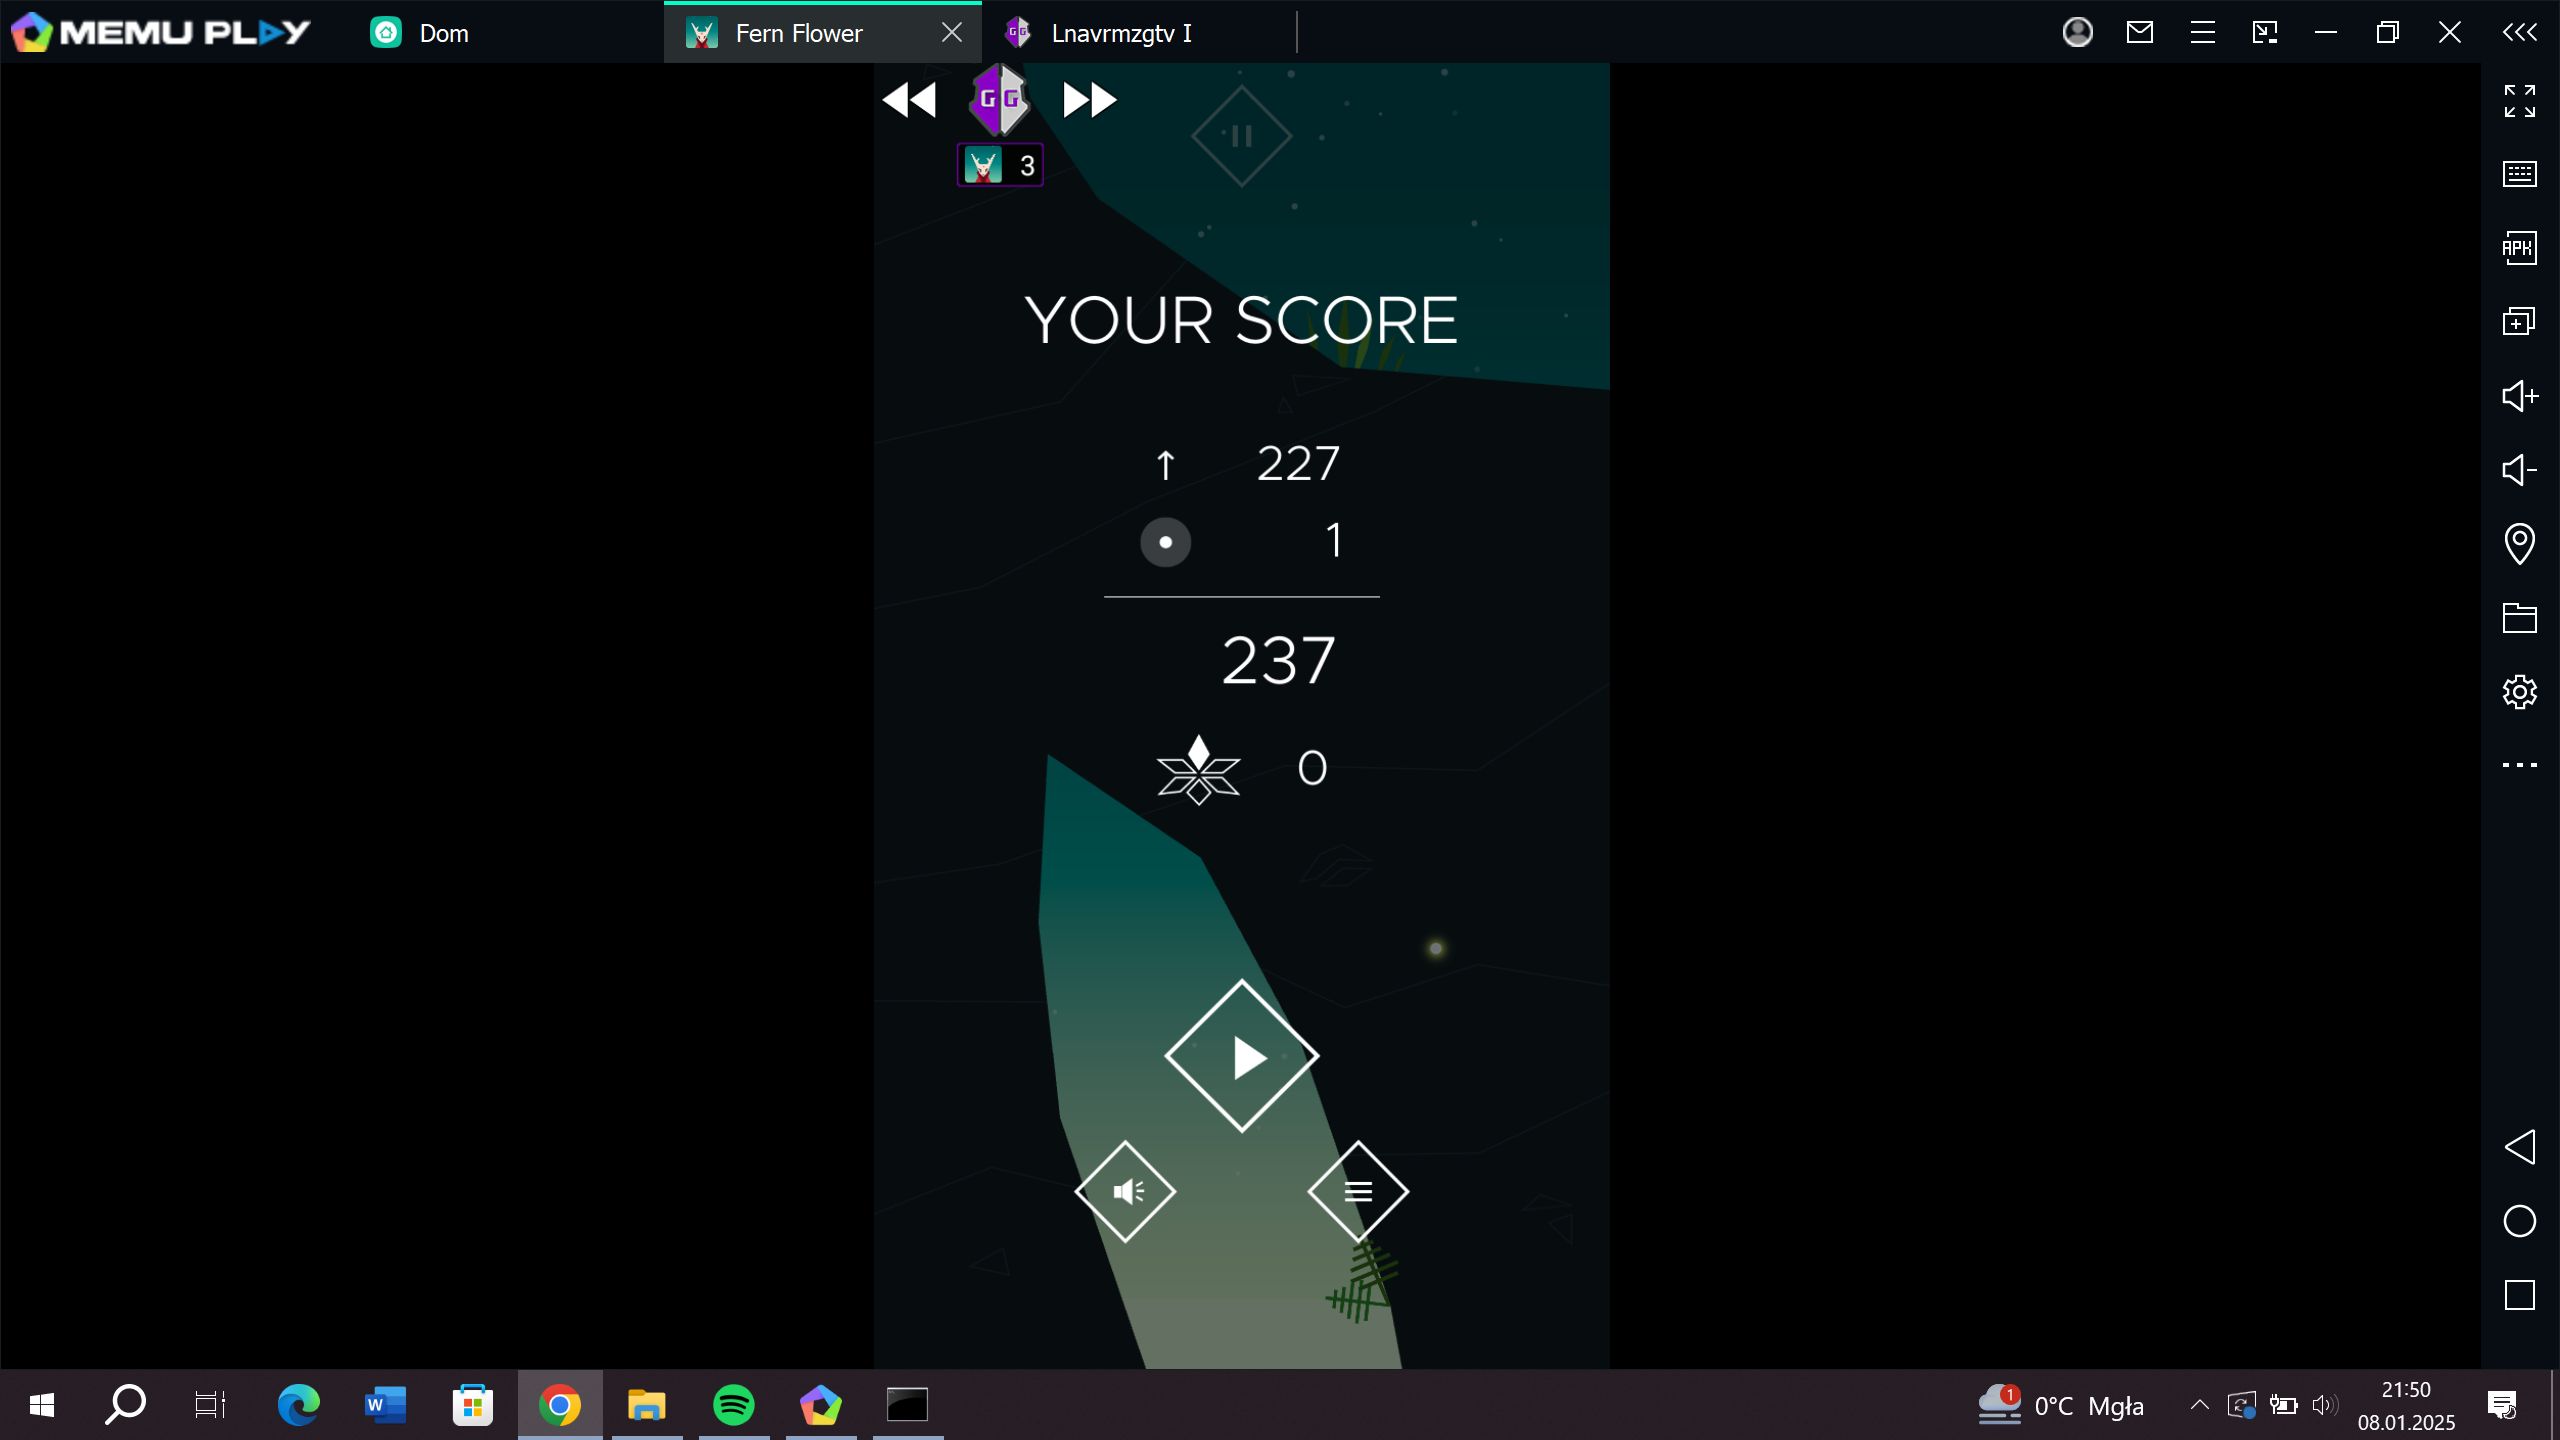

In [202]:
screenshot = pyautogui.screenshot()
screenshot

In [203]:
import numpy as np
np.array(screenshot).shape

(1440, 2560, 3)

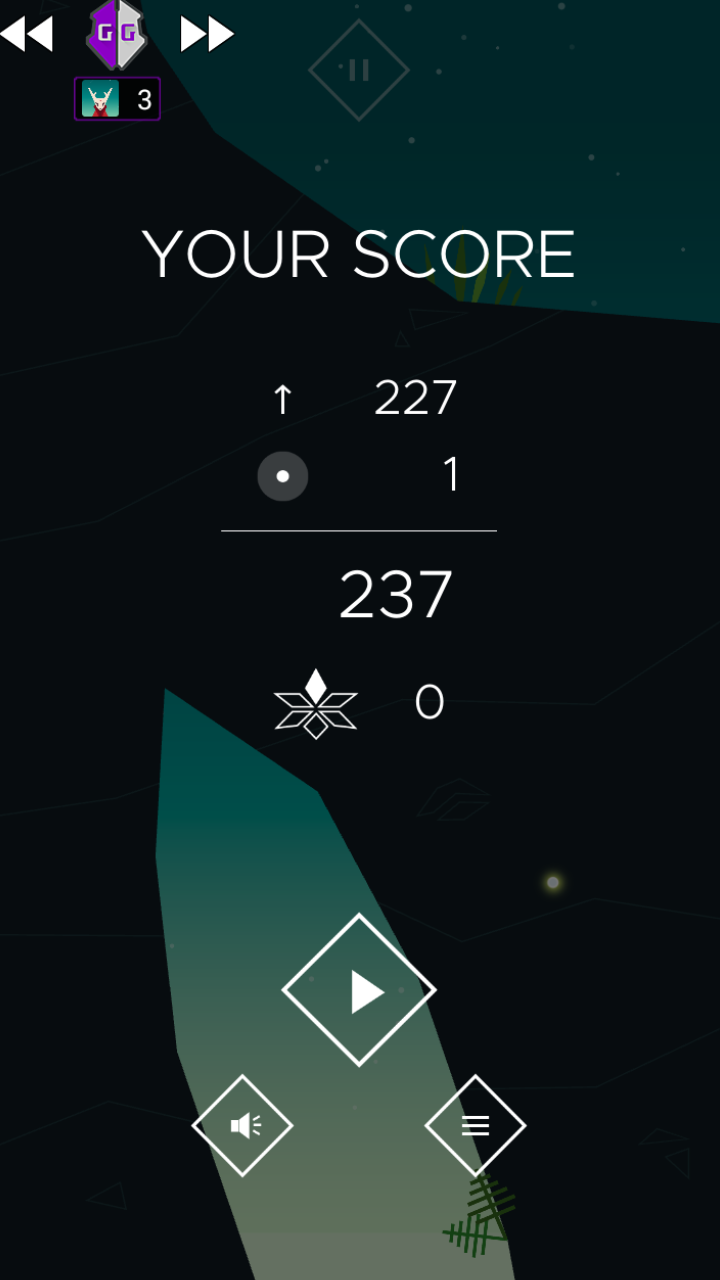

In [204]:
x, y, width, height = 883, 66, 720, 1280
screen_only = screenshot.crop((x, y, x + width, y + height))
screen_only

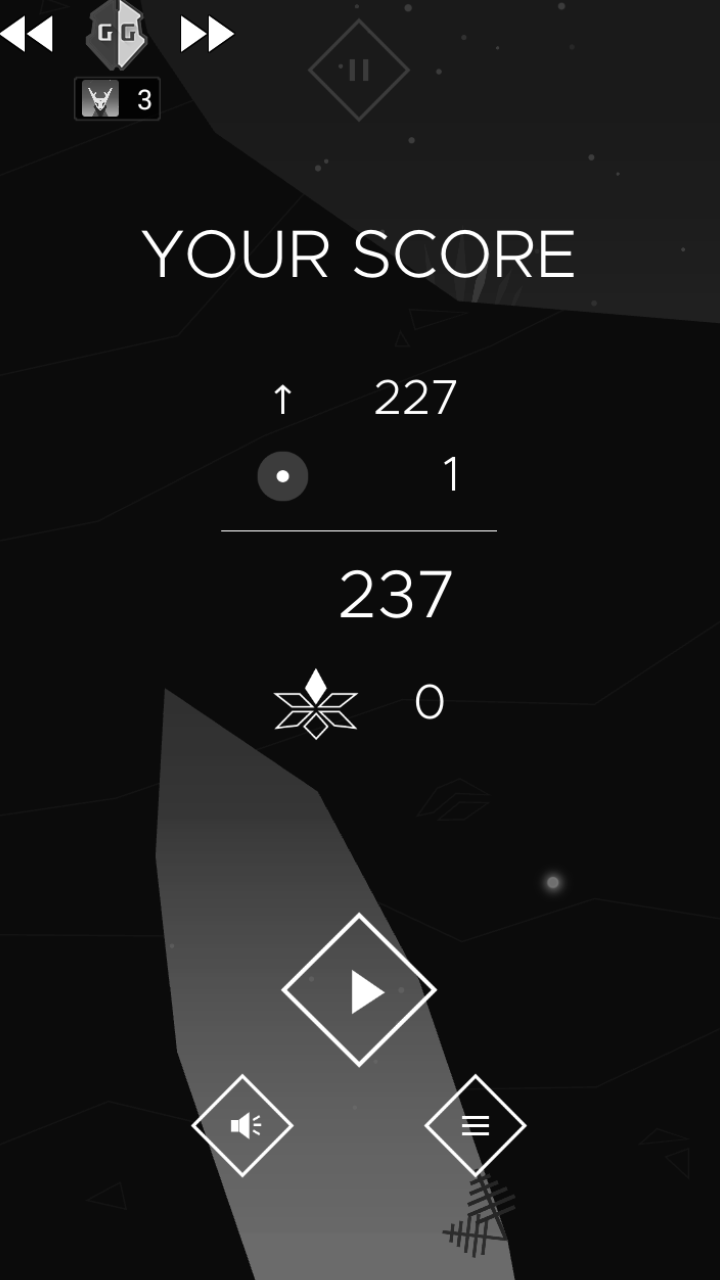

In [205]:
screenshot_bw = screen_only.convert("L") 
screenshot_bw

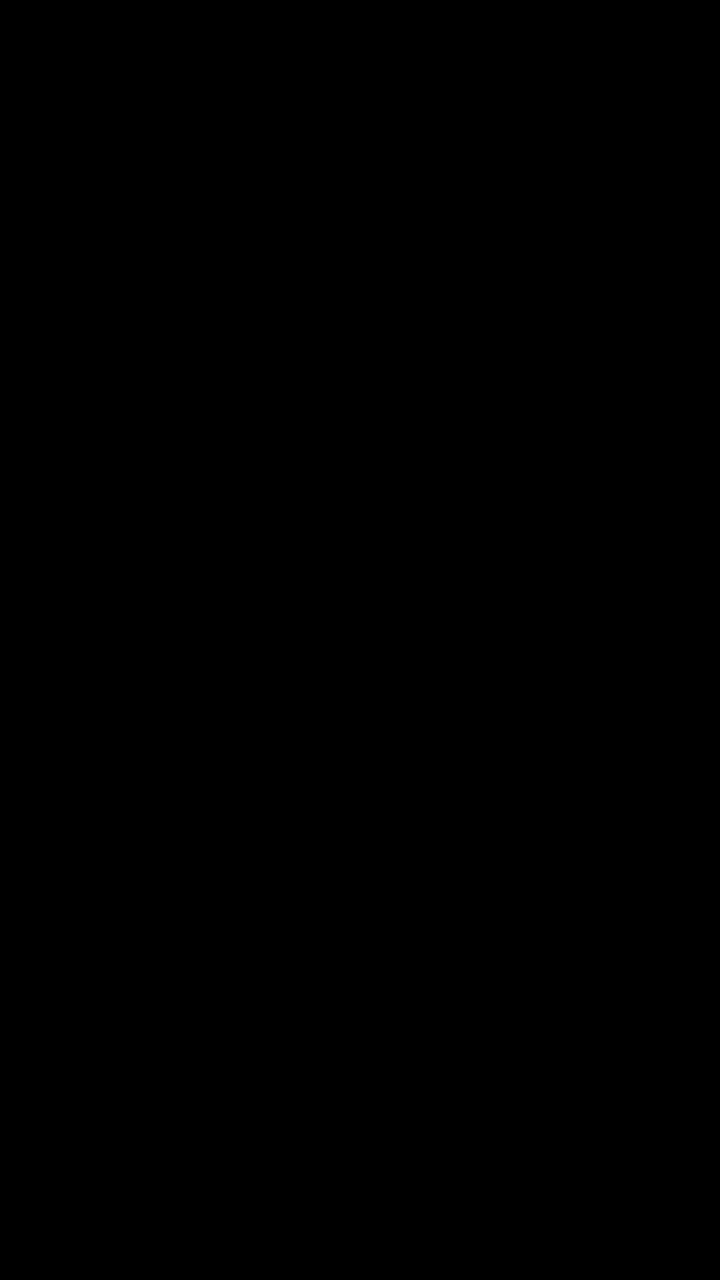

In [206]:
from PIL import Image

ss_shape = np.array(screenshot_bw).shape
mask_play_ss = np.zeros(ss_shape).astype('uint8')
Image.fromarray(mask_play_ss)

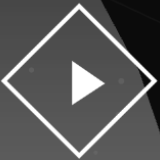

In [207]:
x, y, width, height = 280, 909, 160, 160
cropped_image = screenshot_bw.crop((x, y, x + width, y + height))
cropped_image

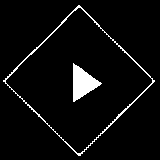

In [217]:
cropped_image_np = np.array(screenshot_bw)[y:y + height, x: x + width]
cropped_image_np_mask = np.where(cropped_image_np == 255, 255, 0).astype('uint8')
Image.fromarray(cropped_image_np_mask)
# cropped_image_np

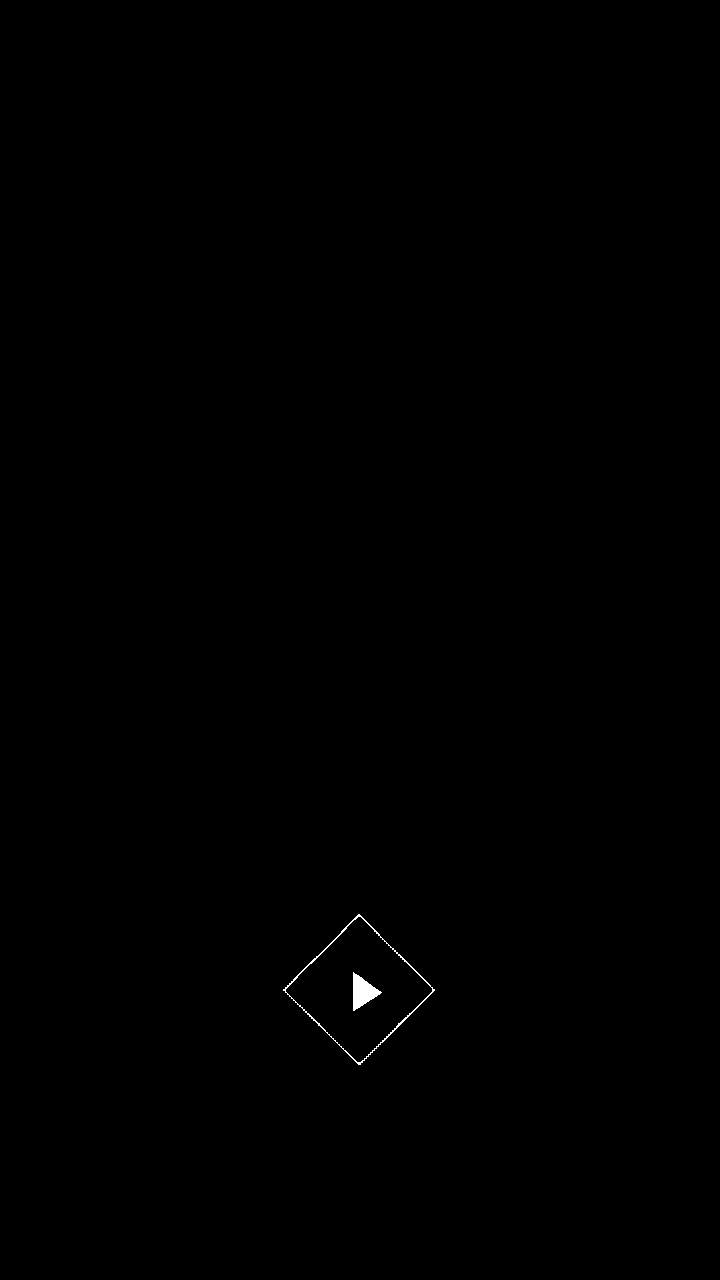

In [218]:
mask_play_ss[y:y + height, x: x + width] = cropped_image_np_mask
masked_play_only = Image.fromarray(mask_play_ss)
masked_play_only

In [219]:
def take_screen_shot():
    screenshot = pyautogui.screenshot()
    x, y, width, height = 883, 66, 720, 1280
    screen_only = screenshot.crop((x, y, x + width, y + height))
    return screen_only

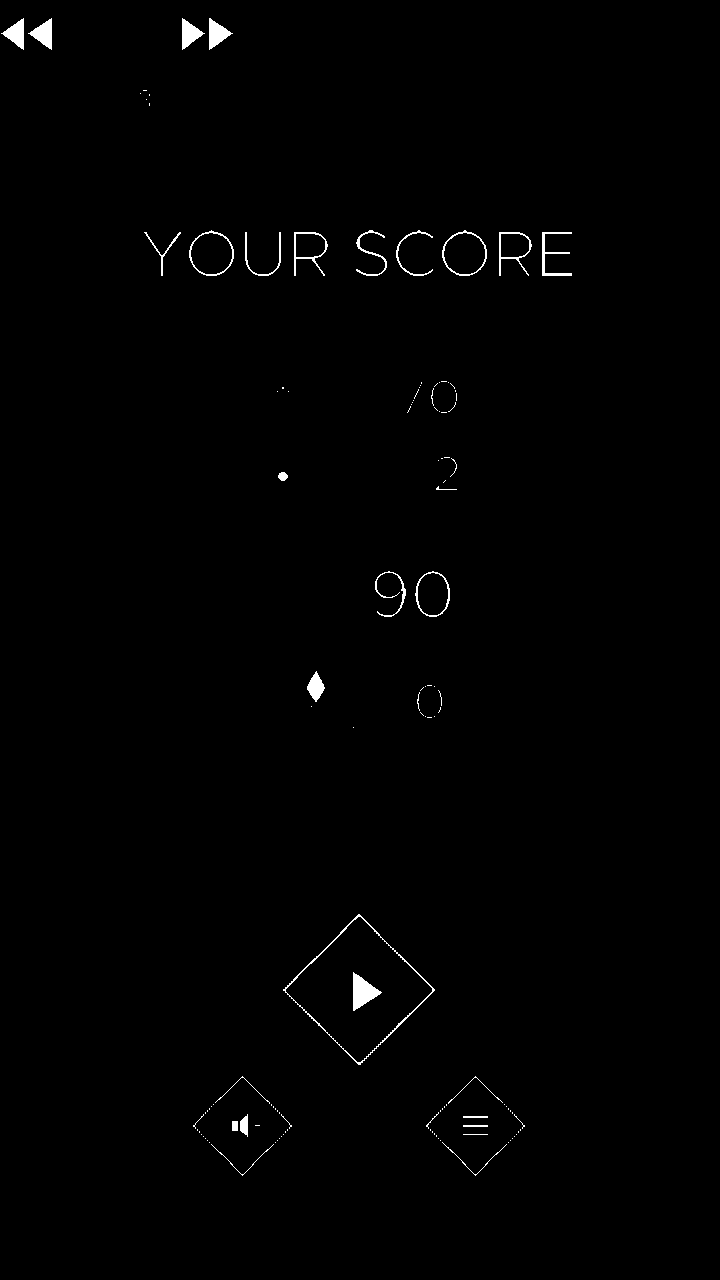

In [230]:
screenshot = take_screen_shot()
screenshot = screenshot.convert("L") 
screenshot_wo = Image.fromarray(np.where(np.array(screenshot) == 255, 255, 0).astype('uint8'))
screenshot_wo

In [231]:
a = np.array(screenshot_wo)[y:y + height, x: x + width] == cropped_image_np_mask

In [232]:
np.sum(a == False)

np.int64(3)

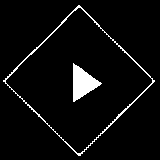

In [233]:
Image.fromarray(cropped_image_np_mask)

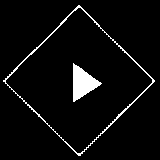

In [234]:
Image.fromarray(np.array(screenshot_wo)[y:y + height, x: x + width])

In [235]:
endgame_screen_mask_part = Image.fromarray(cropped_image_np_mask)
endgame_screen_mask_part.save("base_images/endgame_button_bw.png")

In [272]:
def is_endgame_screen(screenshot: Image, end_image_pattern: Image, possible_fails:int = 50):
    possible_fails = 50
    x, y, width, height = 280, 909, 160, 160 # play button position
    screenshot = screenshot.convert("L") 
    screenshot_wo_np = np.where(np.array(screenshot) == 255, 255, 0).astype('uint8')
    end_image_pattern_np = np.array(end_image_pattern).astype('uint8')
    bool_mask = screenshot_wo_np[y:y + height, x: x + width] == end_image_pattern_np
    if np.sum(bool_mask == False) < possible_fails:
        return True

In [ ]:
pyautogui.click(1483, 1195)
time.sleep(0.2)
pyautogui.click(1243, 1055)

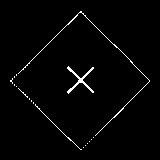

In [289]:
screenshot_end_2 = take_screen_shot()
screenshot_end_2 = screenshot_end_2.convert("L") 
screenshot_2_wo = Image.fromarray(np.where(np.array(screenshot_end_2) == 255, 255, 0).astype('uint8'))
x, y, width, height = 520, 1056, 160, 160 # x revive button position
x_revive_button = screenshot_2_wo.crop((x, y, x + width, y + height))
x_revive_button

In [290]:
x_revive_button.save("base_images/x_revive_button_bw.png")

In [294]:
def is_revive_screen(screenshot: Image, x_revive_pattern: Image, possible_fails:int = 50):
    possible_fails = 50
    x, y, width, height = 520, 1056, 160, 160 # x revive button position
    screenshot = screenshot.convert("L") 
    screenshot_wo_np = np.where(np.array(screenshot) == 255, 255, 0).astype('uint8')
    x_revive_pattern_np = np.array(x_revive_pattern).astype('uint8')
    bool_mask = screenshot_wo_np[y:y + height, x: x + width] == x_revive_pattern_np
    if np.sum(bool_mask == False) < possible_fails:
        return True

In [295]:
# reasume after result
pyautogui.click(1243, 1055)

In [296]:
# x - close, not revive
pyautogui.click(1483, 1202)

In [291]:
base_pattern = Image.open("base_images/endgame_button_bw.png")
x_revive_pattern = Image.open("base_images/x_revive_button_bw.png")

In [302]:
import time

pyautogui.click(1483, 1202)
time.sleep(0.2)
pyautogui.click(1243, 1055)

sleep_time = 0.05

while True:
    pyautogui.keyDown('right')
    time.sleep(sleep_time)
    pyautogui.keyUp('right')
    time.sleep(sleep_time)
    
    pyautogui.keyDown('left')
    time.sleep(sleep_time)
    pyautogui.keyUp('left')
    ss = take_screen_shot()

    if is_revive_screen(ss, x_revive_pattern):
        print("REVIVE SCREEN")
        pyautogui.click(1483, 1202)
        time.sleep(0.2)

    if is_endgame_screen(ss, base_pattern):
        print("END GAME")
        pyautogui.click(1243, 1055)
        time.sleep(0.2)

END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
END GAME
REVIVE SCREEN
END GAME
END GAME
END GAME


KeyboardInterrupt: 

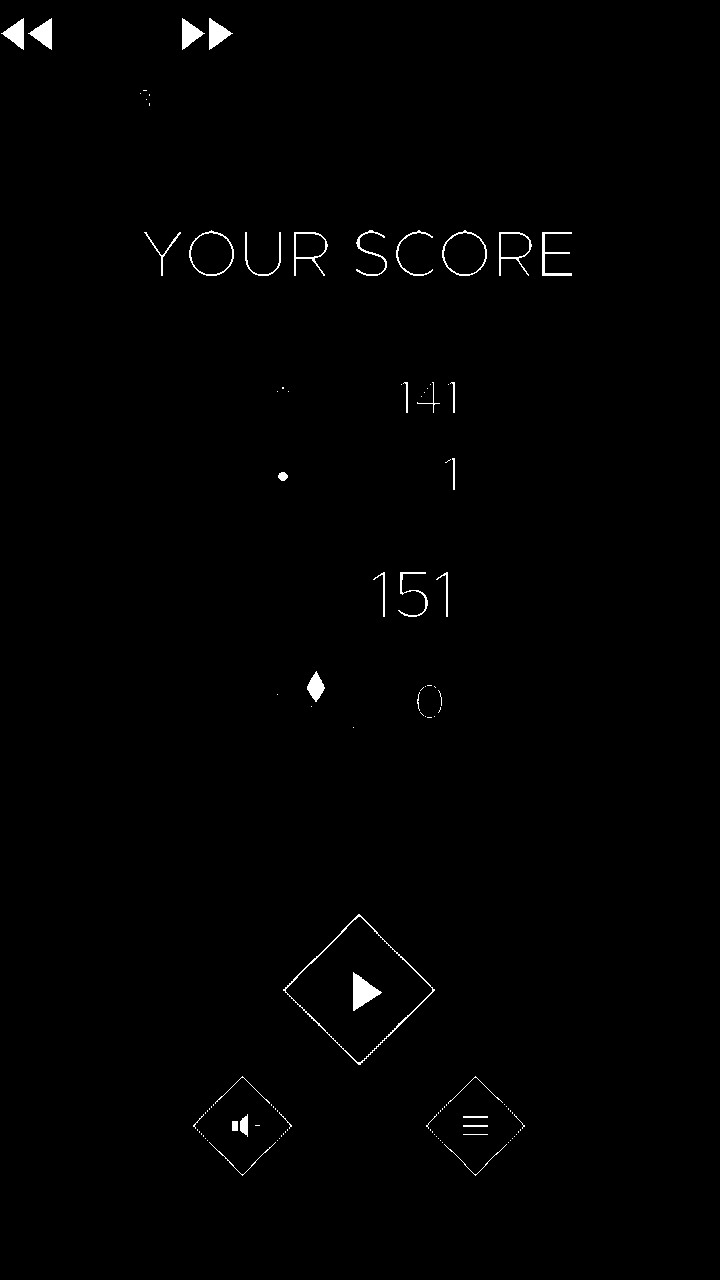

In [306]:
screenshot = take_screen_shot()
screenshot_bw = screenshot.convert("L") 
screenshot_wo = Image.fromarray(np.where(np.array(screenshot_bw) == 255, 255, 0).astype('uint8'))
screenshot_wo

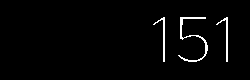

In [326]:
x, y, width, height = 220, 555, 250, 80
result = screenshot_wo.crop((x, y, x + width, y + height))
result

In [328]:
np.array(result).shape

(80, 250)

In [349]:
import easyocr
from PIL import Image
reader = easyocr.Reader(['en'])

def extract_results_from_ss(screenshot, reader=reader):
    screenshot_bw = screenshot.convert("L") 
    screenshot_wo = Image.fromarray(np.where(np.array(screenshot_bw) == 255, 255, 0).astype('uint8'))
    x, y, width, height = 220, 555, 250, 80 # result place
    result_img = screenshot_wo.crop((x, y, x + width, y + height))
    result = reader.readtext(np.array(result_img))
    numbers = ''.join([text[1] for text in result if text[1].isdigit()])

    try:
        numbers = int(numbers)
        return numbers
    except:
        return -1


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [350]:
extract_results_from_ss(screenshot)

151

In [354]:
import time

sleep_time = 0.045
sleep_time_gui_controll = 0.2
N = 30

pyautogui.click(1483, 1202)
time.sleep(sleep_time_gui_controll)
pyautogui.click(1243, 1055)

max_result = 0
i=0

while i < N:
    pyautogui.keyDown('right')
    time.sleep(sleep_time)
    pyautogui.keyUp('right')
    time.sleep(sleep_time)
    
    pyautogui.keyDown('left')
    time.sleep(sleep_time)
    pyautogui.keyUp('left')
    ss = take_screen_shot()

    if is_revive_screen(ss, x_revive_pattern):
        print("REVIVE SCREEN")
        pyautogui.click(1483, 1202)
        time.sleep(sleep_time_gui_controll)

    if is_endgame_screen(ss, base_pattern):
        time.sleep(sleep_time_gui_controll)
        new_ss = take_screen_shot() # second ss after sleep to avoid using screen without displayed results
        result = extract_results_from_ss(new_ss)
        max_result = max(max_result, result)
        i += 1
        print(f"END GAME: [{result} pts]")
        pyautogui.click(1243, 1055)
        time.sleep(sleep_time_gui_controll)

print(f"MAX RESULT: {max_result}")

END GAME: [-1 pts]
END GAME: [36 pts]
END GAME: [35 pts]
END GAME: [22 pts]
END GAME: [48 pts]
END GAME: [48 pts]
END GAME: [21 pts]
END GAME: [35 pts]
END GAME: [21 pts]
END GAME: [29 pts]


FailSafeException: PyAutoGUI fail-safe triggered from mouse moving to a corner of the screen. To disable this fail-safe, set pyautogui.FAILSAFE to False. DISABLING FAIL-SAFE IS NOT RECOMMENDED.

In [ ]:
# memu emulator, root, gameguard speedhack x3